# Policyscope Tutorial

Этот ноутбук демонстрирует основные приёмы офлайн-оценки политик в библиотеке **Policyscope**.

## Краткая теория IPS/SNIPS/DM/DR

**IPS (Inverse Propensity Scoring)** — пересчитывает значения метрики, масштабируя наблюдения на отношение вероятностей выбранного действия в новой и исходной политиках. Предполагает, что известны вероятности действий в логирующей политике и выполнено условие полноты (каждое действие имеет ненулевую вероятность).

**SNIPS** — нормализованный вариант IPS: веса делятся на их сумму, что снижает дисперсию ценой небольшой смещённости. Предположения те же, что и у IPS.

**DM (Direct Method)** — строит модель отклика \(\hat{\mu}(x,a)\) и усредняет её предсказания под новой политикой. Требует корректно специфицированной модели исхода и предпосылки невмешательства (отсутствие скрытых факторов).

**DR (Doubly Robust)** — сочетает DM и IPS. Оценка остаётся несмещённой, если корректен хотя бы один из компонентов: модель отклика или пропенсити.

## Формат ожидаемых логов

Логи политики A представлены в `pandas.DataFrame` и должны содержать следующие столбцы:

| Колонка | Тип | Описание |
| --- | --- | --- |
| `user_id` | int64 | идентификатор пользователя |
| `a_A` | int64 | действие, показанное политикой A |
| `propensity_A` | float64 | вероятность выбора действия `a_A` |
| `accept` | int64 (0/1) | отклик пользователя |
| `cltv` | float64 | ценность при принятии |
| дополнительные признаки (например, `loyal`, `age`, `risk`, `income`, `region`, `age_z`, `risk_z`, `income_z`) | соответствующие типы | используется моделью отклика |

## Демонстрация вычисления ATE на синтетике
Сгенерируем синтетические логи для политики A и оценим, насколько политика B могла бы повысить вероятность принятия предложения. Для проверки сравним оценки с истинным значением (оракулом).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from policyscope.synthetic import SynthConfig, SyntheticRecommenderEnv
from policyscope.policies import make_policy
from policyscope.estimators import train_mu_hat, prepare_piB_taken, ips_value, snips_value, dm_value, dr_value, ate_from_values

In [2]:
cfg = SynthConfig(n_users=5000, seed=42)
env = SyntheticRecommenderEnv(cfg)
X = env.sample_users()

policyA = make_policy("epsilon_greedy", seed=42, epsilon=0.15)
policyB = make_policy("softmax", seed=42, tau=0.7)

logs = env.simulate_logs_A(policyA, X)
logs.head()

,user_id,loyal,age,risk,income,region,age_z,risk_z,income_z,a_A,propensity_A,accept,cltv
0,0,0,35,0.501541,14575.147294,1,-0.416667,0.006164,-1.842693,0,0.8875,1,236.325594
1,1,1,29,0.732395,26513.050864,2,-0.916667,0.929582,-0.646610,2,0.8875,1,826.611167
2,2,0,45,0.188225,22144.013597,0,0.416667,-1.247099,-1.006583,0,0.8875,0,189.567727
3,3,0,52,0.443791,38523.334086,4,1.000000,-0.224838,0.100297,0,0.8875,1,604.329549
4,4,1,31,0.532530,24493.569649,3,-0.750000,0.130121,-0.804989,2,0.8875,0,623.350392


In [3]:
mu = train_mu_hat(logs, target="accept")
piB_taken = prepare_piB_taken(logs, policyB)

# on-policy value for A
vA = logs["accept"].mean()

# estimates for B
vB_ips, ess_ips, clip_ips = ips_value(logs, piB_taken, target="accept")
vB_snips, _, _ = snips_value(logs, piB_taken, target="accept")
vB_dm = dm_value(logs, policyB, mu, target="accept")
vB_dr, ess_dr, clip_dr = dr_value(logs, policyB, mu, target="accept")

# oracle values
oracle_A = env.oracle_value(policyA, X, metric="accept")
oracle_B = env.oracle_value(policyB, X, metric="accept")

# ATEs
ips_ate = ate_from_values(vB_ips, vA)
snips_ate = ate_from_values(vB_snips, vA)
dm_ate = ate_from_values(vB_dm, vA)
dr_ate = ate_from_values(vB_dr, vA)
oracle_ate = oracle_B - oracle_A

results = pd.DataFrame({
    'Estimator': ['IPS', 'SNIPS', 'DM', 'DR', 'Oracle'],
    'V_B': [vB_ips, vB_snips, vB_dm, vB_dr, oracle_B],
    'ATE': [ips_ate, snips_ate, dm_ate, dr_ate, oracle_ate]
})
results

,Estimator,V_B,ATE
0,IPS,0.533687,-0.010913
1,SNIPS,0.541583,-0.003017
2,DM,0.544282,-0.000318
3,DR,0.541570,-0.003030
4,Oracle,0.532400,-0.008000


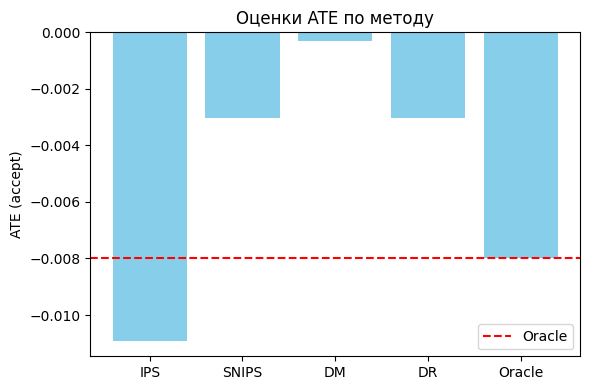

In [4]:
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(results['Estimator'], results['ATE'], color='skyblue')
ax.axhline(oracle_ate, color='red', linestyle='--', label='Oracle')
ax.set_ylabel('ATE (accept)')
ax.set_title('Оценки ATE по методу')
ax.legend()
plt.tight_layout()
plt.show()